In [1]:
# Import Required Packages
import os
import pandas as pd
import numpy as np
import plotly.io as pio
pio.renderers.default = "jupyterlab"
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from interfaces.postprocessing import BR_rVE_RTformat_wrapper_peak_detection as pp_peak_detection
import analysis.data_importing as imp  # Custom importing module
import analysis.plotting as pl  # Custom plotting module
import interfaces.postprocessing as pif  # post-processing interface
import scipy.signal
import warnings
import dtw  # Dynamic Time Warping

import external.custom_post.custom_post_copy as cpc

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Data Cleaning Block
activity_data_dir = "data/c220e0e4-d30d-4ead-858a-1545b91bc362"
uncleaned_data_dir = os.path.join(activity_data_dir, "uncleaned_data")
cleaned_data_dir =  activity_data_dir
# check if the activity data directory contains pickled data:
pkl_names = ["aws_b3_df.pkl", "aws_time_df.pkl", "live_b3_df.pkl", "raw_slow_df.pkl"]
clean_dfs = {}
for name in pkl_names:
    if not os.path.exists(os.path.join(uncleaned_data_dir, name)):
        print("No pickled data found in activity data directory. Cleaning data...")
        clean_dfs = imp.clean_all_data(uncleaned_data_dir, create_dir = True)
        break
    # if not, clean the data and save it
if clean_dfs == {}:
    print("Pickled data found in activity data directory. Loading data...")
    clean_dfs = imp.load_cleaned_data(uncleaned_data_dir)

Pickled data found in activity data directory. Loading data...


In [3]:
live_b3_df = clean_dfs["live_b3_df"] # Live data (only have breath-to-breath)
pp_b3_df = clean_dfs["aws_b3_df"] #
pp_time_df = clean_dfs["aws_time_df"] #

In [4]:
VE_live = pd.DataFrame(live_b3_df["VE"].set_axis(live_b3_df["breathTime"])).dropna()
VE_pp_b3 = pd.DataFrame(pp_b3_df["VE"].set_axis(pp_b3_df["breathTime"])).dropna()
VE_pp_time = pd.DataFrame(pp_time_df["VE"].set_axis(pp_time_df["Time"])).dropna()

In [23]:
# Plotting Block for VE
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=VE_live.index, y=VE_live["VE"], name="Live Data"), row=1, col=1)
fig.add_trace(go.Scatter(x=VE_pp_b3.index, y=VE_pp_b3["VE"], name="Post-Processed Data (B3)"), row=1, col=1)
fig.add_trace(go.Scatter(x=VE_pp_time.index, y=VE_pp_time["VE"], name="Post-Processed Data (Time)"), row=1, col=1)

## Notes on VE
### Post-Processed Data: Second-to-second vs Breath-to-breath
There is really no difference between the post-processed second-to-second data (VE_pp_time) and the post-processed breath-to-breath data (VE_pp_b3)
If we are looking at second-second interpolation on the live for second-to-second error comparison, don't need to interpolate the breath-to-breath data and can use the provided second to second data

### Time-shifting the live
There is a noticiable time-shift on the live. Its on the order of seconds, but if we are looking at the sceond to second error, this will cause large deviations when there are large shifts



# VT Data

In [6]:
VT_live = pd.DataFrame(live_b3_df["VT"].set_axis(live_b3_df["breathTime"]))
VT_pp_b3 = pd.DataFrame(pp_b3_df["VT"].set_axis(pp_b3_df["breathTime"]))
VT_pp_time = pd.DataFrame(pp_time_df["VT"].set_axis(pp_time_df["Time"]))


In [7]:
# Plotting Block for VT
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=VT_live.index, y=VT_live["VT"], name="Live Data"), row=1, col=1)
fig.add_trace(go.Scatter(x=VT_pp_b3.index, y=VT_pp_b3["VT"], name="Post-Processed Data (B3)"), row=1, col=1)
fig.add_trace(go.Scatter(x=VT_pp_time.index, y=VT_pp_time["VT"], name="Post-Processed Data (Time)"), row=1, col=1)

## Notes on VT
### Post-Processed Data: Second-to-second vs Breath-to-breath
The second-to-second VT uses an aggressive smoothing process as there is a large difference between the two.

### Time-shifting the live
Once again there is a noticeable time shift on the live


# Breathing Rate

In [8]:
iBR_live = pd.DataFrame(live_b3_df["instBR"].set_axis(live_b3_df["breathTime"]))
aBR_live = pd.DataFrame(live_b3_df["RRAvg"].set_axis(live_b3_df["breathTime"]))
iBR_pp_b3 = pd.DataFrame(pp_b3_df["instBR"].set_axis(pp_b3_df["breathTime"]))
aBR_pp_b3 = pd.DataFrame(pp_b3_df["RRAvg"].set_axis(pp_b3_df["breathTime"]))
BR_pp_time = pd.DataFrame(pp_time_df["BR"].set_axis(pp_time_df["Time"]))

In [9]:
# Plotting Block for BR
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=iBR_live.index, y=iBR_live["instBR"], name="Live Data (Instantaneous)"), row=1, col=1)
fig.add_trace(go.Scatter(x=aBR_live.index, y=aBR_live["RRAvg"], name="Live Data (Average)"), row=1, col=1)
fig.add_trace(go.Scatter(x=iBR_pp_b3.index, y=iBR_pp_b3["instBR"], name="Post-Processed Data (Instantaneous)"), row=1, col=1)
fig.add_trace(go.Scatter(x=aBR_pp_b3.index, y=aBR_pp_b3["RRAvg"], name="Post-Processed Data (Average)"), row=1, col=1)
fig.add_trace(go.Scatter(x=BR_pp_time.index, y=BR_pp_time["BR"], name="Post-Processed Data (Time)"), row=1, col=1)


## Notes on BR
### Post-Processed Data: Second-to-second vs Breath-to-breath
The second-to-second is a smoother versionof the "RRAvg" in the breath-to-breath data

### Time-shifting the live
Present as always

# Dynamic Time Warping
DTW can be applied to datasets that differ in their sampling frequency and/or length.
Instead of a 1-to-1 match of data points, DTW allows for a 1-to-many match of data points.
This is done by creating a cost matrix between the two datasets and finding the path with the lowest cost.


In [26]:
# First select a subset of data where the index is between 400 and 400 seconds
t_start = 200
t_end = 400
VE_live_subset = VE_live.loc[(VE_live.index >= t_start) & (VE_live.index <= t_end)]
VE_pp_b3_subset = VE_pp_b3.loc[(VE_pp_b3.index >= t_start) & (VE_pp_b3.index <= t_end)]
if True:
    # Plot the two subsets using markers instead of lines
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
    fig.add_trace(go.Scatter(x=VE_live_subset.index, y=VE_live_subset["VE"], name="Live Data"), row=1, col=1)
    fig.add_trace(go.Scatter(x=VE_pp_b3_subset.index, y=VE_pp_b3_subset["VE"], name="Post-Processed Data (B3)"), row=1, col=1)
    #fig.update_traces(mode="markers", marker=dict(size=5))
    fig.show()

<Axes: >

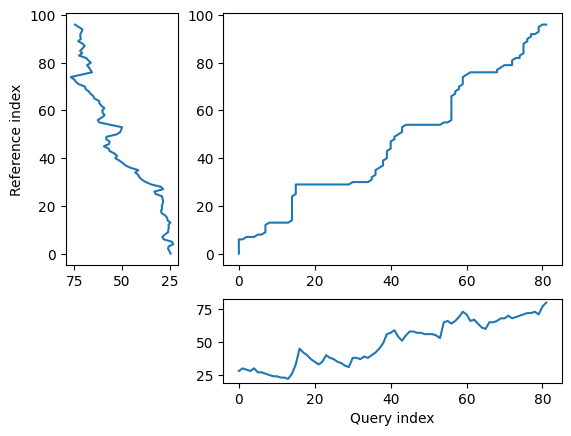

In [11]:
alignment = dtw.dtw(VE_live_subset["VE"], VE_pp_b3_subset["VE"], keep_internals=True)
alignment.plot(type = "threeway")

<Axes: >

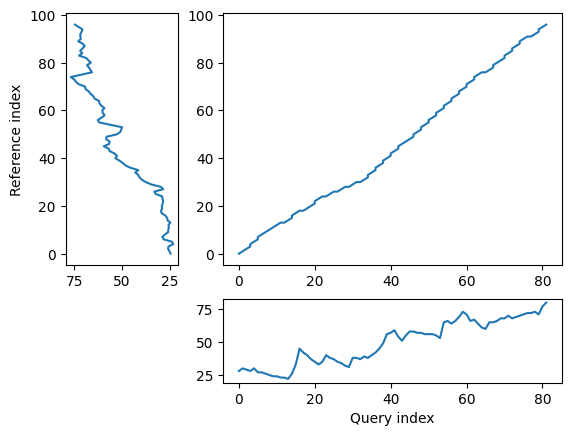

In [12]:
dtw.dtw(VE_live_subset["VE"], VE_pp_b3_subset["VE"], keep_internals=True,  step_pattern=dtw.rabinerJuangStepPattern(6, "c")).plot(type="threeway",offset=-2)

<Axes: xlabel='Query index', ylabel='Reference index'>

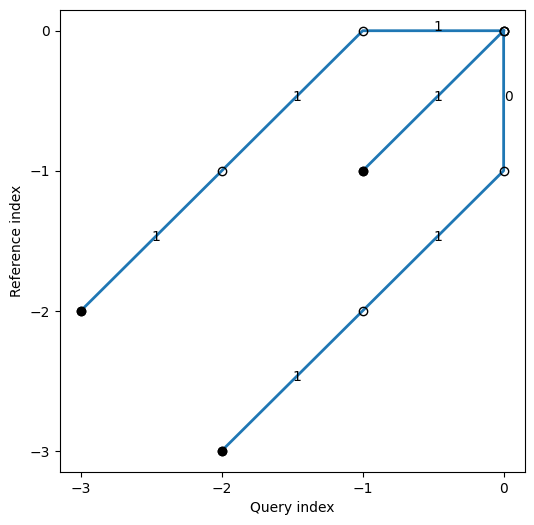

In [13]:
dtw.rabinerJuangStepPattern(6,"c").plot()


In [14]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis


In [15]:
# interpolate data series to second-by-second indices
def interpolate_data(df):
    if df.index.dtype == "float64":
        df.index = df.index.astype("int")
    df_interp = df.interpolate(method="index")
    # Take average if there are multiple values for the same index
    df_interp = df_interp.groupby(df_interp.index).mean()
    s_range = np.arange(min(df_interp.index),max(df_interp.index))
    sec_df = pd.DataFrame(s_range, index=s_range)
    df_sec = df_interp.join(sec_df, how="outer")
    df_sec = df_sec.interpolate(method="index").drop(columns = [0])
    return df_sec

VE_live_subset_sec = interpolate_data(VE_live_subset)
VE_pp_b3_subset_sec = interpolate_data(VE_pp_b3_subset)
# make indices equal
min_index = max(VE_live_subset_sec.index.min(), VE_pp_b3_subset_sec.index.min())
max_index = min(VE_live_subset_sec.index.max(), VE_pp_b3_subset_sec.index.max())
VE_live_subset_sec = VE_live_subset_sec.loc[(VE_live_subset_sec.index >= min_index) & (VE_live_subset_sec.index <= max_index)]
VE_pp_b3_subset_sec = VE_pp_b3_subset_sec.loc[(VE_pp_b3_subset_sec.index >= min_index) & (VE_pp_b3_subset_sec.index <= max_index)]
# find where indices are not equal
index_diff = VE_live_subset_sec.index != VE_pp_b3_subset_sec.index


In [16]:
# Plot interpolated data
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=VE_live_subset_sec.index, y=VE_live_subset_sec["VE"], name="Live Data"), row=1, col=1)
fig.add_trace(go.Scatter(x=VE_pp_b3_subset_sec.index, y=VE_pp_b3_subset_sec["VE"], name="Post-Processed Data (B3)"), row=1, col=1)
fig.update_traces(mode="markers", marker=dict(size=3))
fig.show()


(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

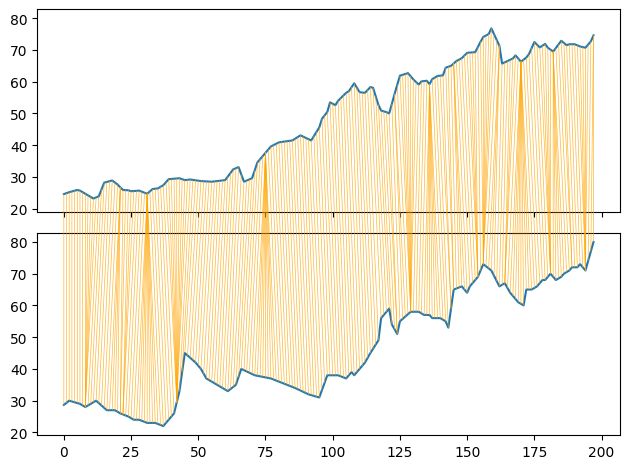

In [17]:
# compute DTW warping path
VE_live_np = VE_live_subset_sec["VE"].to_numpy()
VE_pp_np = VE_pp_b3_subset_sec["VE"].to_numpy()

path = dtw.warping_path(VE_pp_np, VE_live_np, window = 5)
dtwvis.plot_warping(VE_pp_np, VE_live_np, path)

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

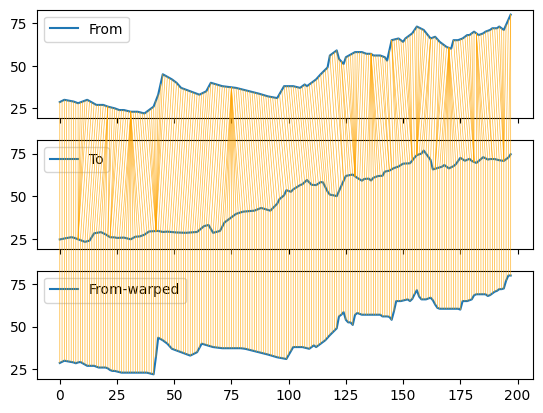

In [22]:
# Warp the live to match the post-processed
VE_live_warped,d = dtw.warp(VE_live_np, VE_pp_np, path)
dtwvis.plot_warp(VE_live_np,VE_pp_np, VE_live_warped, path = path)



In [33]:
# Compute error between warped live and post-processed
error = VE_live_np - VE_pp_np
error_warped = VE_live_warped - VE_pp_np
# plot unwarped signal, warped signal, pp signal and the error
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=VE_live_subset_sec.index, y=VE_live_np, name="Live Data"), row=1, col=1)
fig.add_trace(go.Scatter(x=VE_live_subset_sec.index, y=np.array(VE_live_warped), name="Live Data Warped"), row=1, col=1)
fig.add_trace(go.Scatter(x=VE_live_subset_sec.index, y=VE_pp_np, name="Post-Processed Data (B3)"), row=1, col=1)
fig.add_trace(go.Scatter(x=VE_live_subset_sec.index, y=error, name="Error"), row=2, col=1)
fig.add_trace(go.Scatter(x=VE_live_subset_sec.index, y=error_warped, name="Warped Error"), row=2, col=1)